## Context

This notebook analyzes performance results from preliminary tests of the **ASPA accessibility algorithm** under different data and execution conditions.
Each row in the dataset represents one execution of the algorithm with specific configurations (subset size, attribute sparsity).

The system processes three binary files — **origin**, **destination**, and **accessibility** — corresponding to spatial tiles.
For each test, it filters origin and destination tiles based on selected attributes (non-null values) and then joins them to retrieve accessibility data.

Higher percentages of non-null attribute values generally improve efficiency, as more valid data reduces overhead during filtering and joining.


In [117]:
# !pip install pandas numpy matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [118]:
# Load the CSV file
df = pd.read_csv('report.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")

# Extract numeric values from origin_attr_% and dest_attr_%
df['origin_attr_%'] = df['origin_attr_%'].str.extract(r'(\d+)').astype(int)
df['dest_attr_%'] = df['dest_attr_%'].str.extract(r'(\d+)').astype(int)

df.head()

Dataset shape: (125, 20)

Columns: ['dataset_%', 'origin_attr_%', 'dest_attr_%', 'or_bin_loaded_rows', 'dst_bin_loaded_rows', 'acc_bin_loaded_rows', 'or_bin_loaded_size (B)', 'dst_bin_loaded_size (B)', 'acc_bin_loaded_size (B)', 'or_bin_load_time (s)', 'dst_bin_load_time (s)', 'acc_bin_load_time (s)', 'time_filtering (s)', 'time_write_bin (s)', 'total_time (s)', 'result_acc_size (B)', 'num_threads', 'RAM_min (B)', 'RAM_max (B)', 'RAM_max-min (B)']

First few rows:


dataset_%  origin_attr_%  dest_attr_%  or_bin_loaded_rows  \
0          1              5            5                  89   
1          1              5           25                  89   
2          1              5           50                  89   
3          1              5           75                  89   
4          1              5          100                  89   

   dst_bin_loaded_rows  acc_bin_loaded_rows  or_bin_loaded_size (B)  \
0                    7                15505                     712   
1                   41                90815                     712   
2                   83               183845                     712   
3                  125               276875                     712   
4                  167               369905                     712   

   dst_bin_loaded_size (B)  acc_bin_loaded_size (B)  or_bin_load_time (s)  \
0                       56                   248080              0.000224   
1                      328                  1453040              0.000270   
2                      664                  2941520              0.000392   
3                     1000                  4430000              0.000499   
4                     1336                  5918480              0.000348   

   dst_bin_load_time (s)  acc_bin_load_time (s)  time_filtering (s)  \
0               0.000128               0.000445            0.000991   
1               0.000133               0.004510            0.002056   
2               0.000242               0.009212            0.002269   
3               0.000172               0.011489            0.002469   
4               0.000257               0.013176            0.002786   

   time_write_bin (s)  total_time (s)  result_acc_size (B)  num_threads  \
0            0.000238        0.003169                 9968           16   
1            0.000238        0.008395                58384           16   
2            0.000289        0.014004               118192           16   
3            0.000337        0.016415               178000           16   
4            0.000518        0.018249               237808           16   

   RAM_min (B)  RAM_max (B)  RAM_max-min (B)  
0   4732993536   4733366272           372736  
1   4733046784   4734959616          1912832  
2   4734648320   4737105920          2457600  
3   4705546240   4709646336          4100096  
4   4705001472   4710965248          5963776

### Inputs

* **`dataset_%`** – Percentage of the dataset used (0–100).
* **`origin_attr_%`** – Percentage of non-null values in the selected origin attribute.
* **`dest_attr_%`** – Percentage of non-null values in the selected destination attribute.
* **`num_threads`** – Number of threads used for processing (constant = 16).

---

### Phase 1 – Load Data

* **`or_bin_loaded_rows`** – Origin rows loaded from binary file.
* **`dst_bin_loaded_rows`** – Destination rows loaded from binary file.
* **`acc_bin_loaded_rows`** – Accessibility rows loaded from binary file.
* **`or_bin_loaded_size (B)`** – Size of loaded origin binary file.
* **`dst_bin_loaded_size (B)`** – Size of loaded destination binary file.
* **`acc_bin_loaded_size (B)`** – Size of loaded accessibility binary file.
* **`or_bin_load_time (s)`** – Time to load origin binary file.
* **`dst_bin_load_time (s)`** – Time to load destination binary file.
* **`acc_bin_load_time (s)`** – Time to load accessibility binary file.

---

### Phase 2 – Filter Data

* **`time_filtering (s)`** – Time spent filtering origin and destination tiles based on non-null attribute values.

---

### Phase 3 – Write Results

* **`time_write_bin (s)`** – Time to write filtered accessibility results to binary output.
* **`result_acc_size (B)`** – Size of the resulting filtered accessibility dataset.

---

### Phase 4 – Total Performance and Execution

* **`total_time (s)`** – Total execution time across all phases.
* **`RAM_min (B)`** – Minimum RAM usage during execution.
* **`RAM_max (B)`** – Maximum RAM usage during execution.
* **`RAM_max-min (B)`** – Difference between maximum and minimum RAM usage.


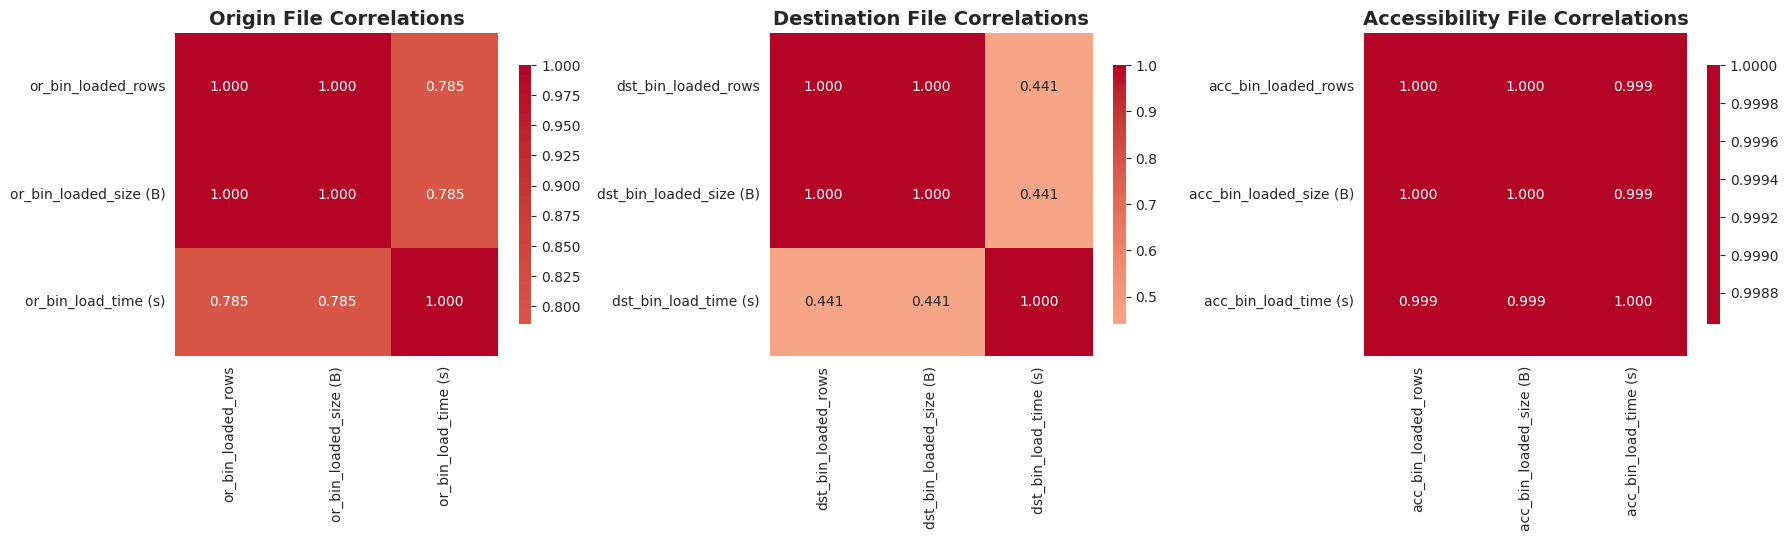

In [119]:
# Visualize Phase 1 correlations with heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Calculate correlation matrices
origin_corr = df[['or_bin_loaded_rows', 'or_bin_loaded_size (B)','or_bin_load_time (s)']].corr()
dest_corr = df[['dst_bin_loaded_rows', 'dst_bin_loaded_size (B)', 'dst_bin_load_time (s)']].corr()
acc_corr = df[['acc_bin_loaded_rows', 'acc_bin_loaded_size (B)', 'acc_bin_load_time (s)']].corr()
# Origin correlations heatmap
sns.heatmap(origin_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, ax=axes[0], cbar_kws={'shrink': 0.8})
axes[0].set_title('Origin File Correlations', fontsize=14, fontweight='bold')

# Destination correlations heatmap
sns.heatmap(dest_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, ax=axes[1], cbar_kws={'shrink': 0.8})
axes[1].set_title('Destination File Correlations', fontsize=14, fontweight='bold')

# Accessibility correlations heatmap
sns.heatmap(acc_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, ax=axes[2], cbar_kws={'shrink': 0.8})
axes[2].set_title('Accessibility File Correlations', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()



### Comment about sizes and expected timing behavior

Each origin and destination row contains two 4-byte columns (8 B total). The accessibility table has four 4-byte columns (16 B total). Size must be directly proportional to the number of rows.

Based on the implementation, origin and destination are indexed and often read as a single block, their load times tend to increase very slowly with dataset size. In contrast, accesibility is a the combination of all origin-destination pairs, so it should grow significantly. We will plot and see below.

Accesibility has indexes by destination ID for faster lookups, which may also affect load time behavior.

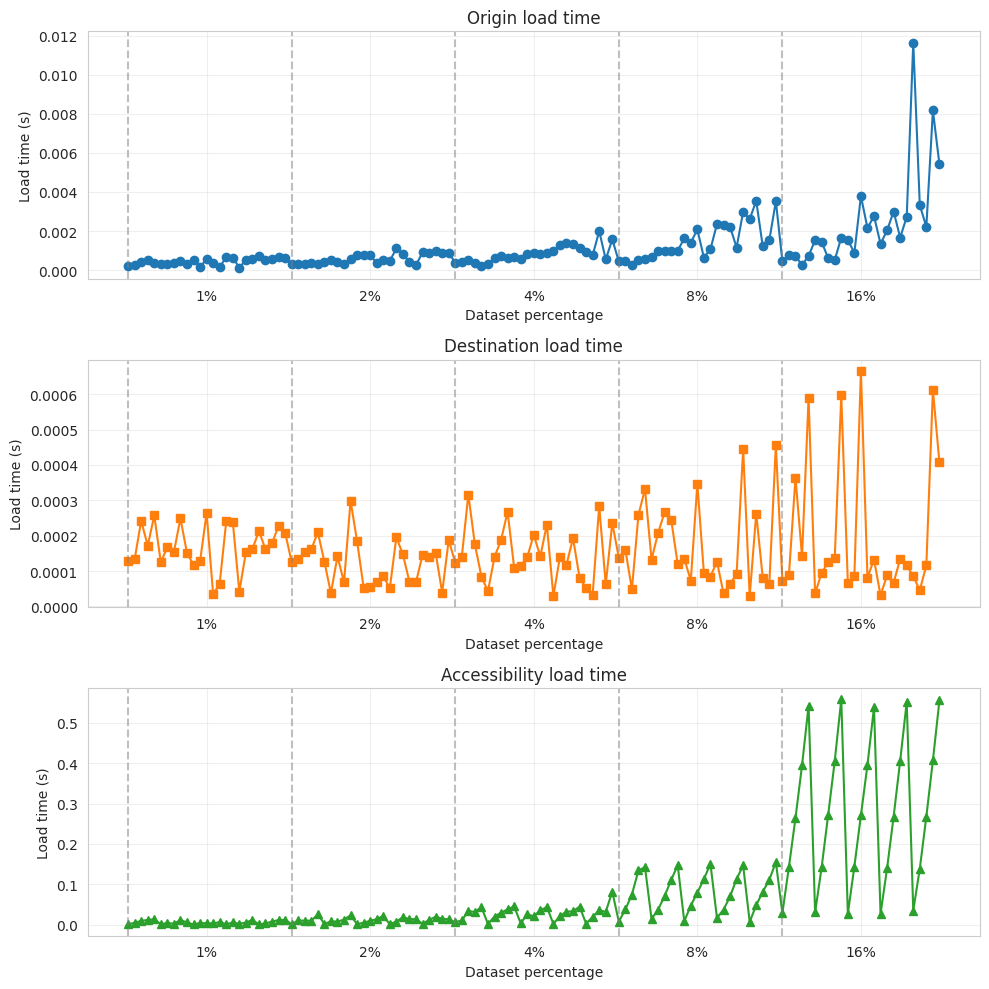

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# x-axis is just row index
x = np.arange(len(df))

# get unique dataset percentages and their boundaries
percentages = df['dataset_%'].unique()
percentages.sort()

# find where each dataset percentage starts
boundaries = []
for p in percentages:
    idx = df.index[df['dataset_%'] == p][0]
    boundaries.append(idx)

fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharey=False)

# Titles for each metric
metrics = [
    ('or_bin_load_time (s)', 'Origin load time', 'C0', 'o'),
    ('dst_bin_load_time (s)', 'Destination load time', 'C1', 's'),
    ('acc_bin_load_time (s)', 'Accessibility load time', 'C2', '^')
]

for ax, (col, title, color, marker) in zip(axes, metrics):
    ax.plot(x, df[col], marker=marker, linestyle='-', color=color)
    ax.set_title(title)
    ax.set_xlabel('Dataset percentage')
    ax.set_ylabel('Load time (s)')
    ax.grid(alpha=0.3)

    # draw vertical lines where dataset% changes
    for b in boundaries:
        ax.axvline(x=b, color='gray', linestyle='--', alpha=0.5)

    # custom x-ticks: place them at the midpoints of each dataset% group
    midpoints = []
    for i in range(len(boundaries)):
        start = boundaries[i]
        end = boundaries[i + 1] if i + 1 < len(boundaries) else len(df)
        midpoints.append((start + end) // 2)
    ax.set_xticks(midpoints)
    ax.set_xticklabels([f"{p}%" for p in percentages])

plt.tight_layout()
plt.show()


As observed, **origin** and **destination** *load times* remain relatively constant across different dataset sizes, indicating efficient block reading. In contrast, **accessibility** load time increases with the number of rows, reflecting its dependence on dataset size.

In [121]:
# Final analysis: table with min/max/mean/std and relative change; independent heatmaps per subplot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1) Statistics table (min, max, mean, std) for origin and destination, plus relative change (%)
dst_times = df['dst_bin_load_time (s)'].dropna()
or_times = df['or_bin_load_time (s)'].dropna()

stats = pd.DataFrame({
    'min': [dst_times.min(), or_times.min()],
    'max': [dst_times.max(), or_times.max()],
    'mean': [dst_times.mean(), or_times.mean()],
    'std': [dst_times.std(ddof=1), or_times.std(ddof=1)]
}, index=['destination', 'origin'])

# Relative change (destination vs origin) as percentage
rel = ((stats.loc['origin'] - stats.loc['destination']) / stats.loc['destination']) * 100
rel.name = 'relative_change_%'

# Build display table: keep numeric rows formatted to 6 decimals, relative change to 2 decimals with % sign
display_df = stats.copy()
display_df.loc['relative_change_%'] = rel

display_df_formatted = display_df.copy().astype(object)
for r in ['destination', 'origin']:
    display_df_formatted.loc[r] = display_df.loc[r].map(lambda x: f"{x:.6f}")
display_df_formatted.loc['relative_change_%'] = display_df.loc['relative_change_%'].map(lambda x: f"{x:.2f}%")

print('\n=== Summary table (min / max / mean / std) ===')
print(display_df_formatted.to_string())




=== Summary table (min / max / mean / std) ===
                        min       max      mean       std
destination        0.000029  0.000666  0.000162  0.000121
origin             0.000117  0.011647  0.001157  0.001447
relative_change_%   301.86%  1649.83%   614.82%  1098.65%


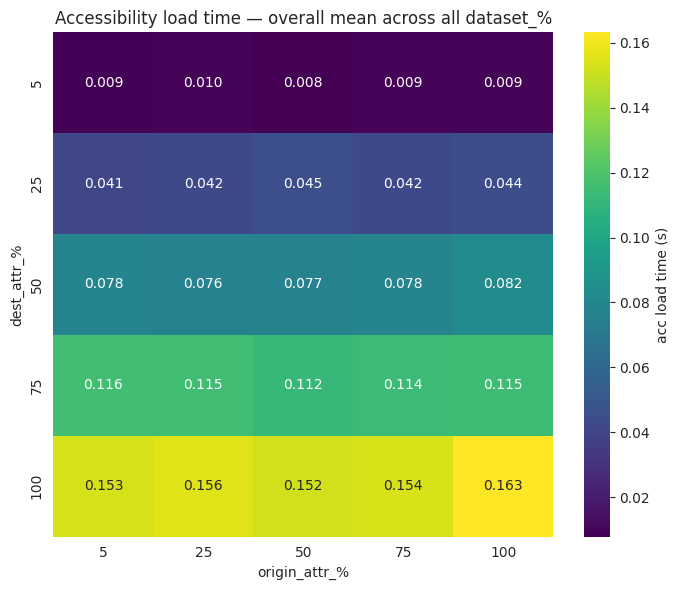

In [122]:
# 2) Accessibility heatmaps
acc_col = 'acc_bin_load_time (s)'
x_col = 'origin_attr_%'
y_col = 'dest_attr_%'
p_col = 'dataset_%'

# Overall mean heatmap (aggregated across all dataset_% values) - independent color scale
pivot_overall = df.pivot_table(index=y_col, columns=x_col, values=acc_col, aggfunc='mean')
pivot_overall = pivot_overall.sort_index(axis=0).sort_index(axis=1)
plt.figure(figsize=(7, 6))
vmin_o = np.nanmin(pivot_overall.values) if np.isfinite(np.nanmin(pivot_overall.values)) else None
vmax_o = np.nanmax(pivot_overall.values) if np.isfinite(np.nanmax(pivot_overall.values)) else None
sns.heatmap(pivot_overall, annot=True, fmt='.3f', cmap='viridis', vmin=vmin_o, vmax=vmax_o, cbar_kws={'label': 'acc load time (s)'})
plt.title('Accessibility load time — overall mean across all dataset_%')
plt.xlabel('origin_attr_%')
plt.ylabel('dest_attr_%')
plt.tight_layout()
plt.show()


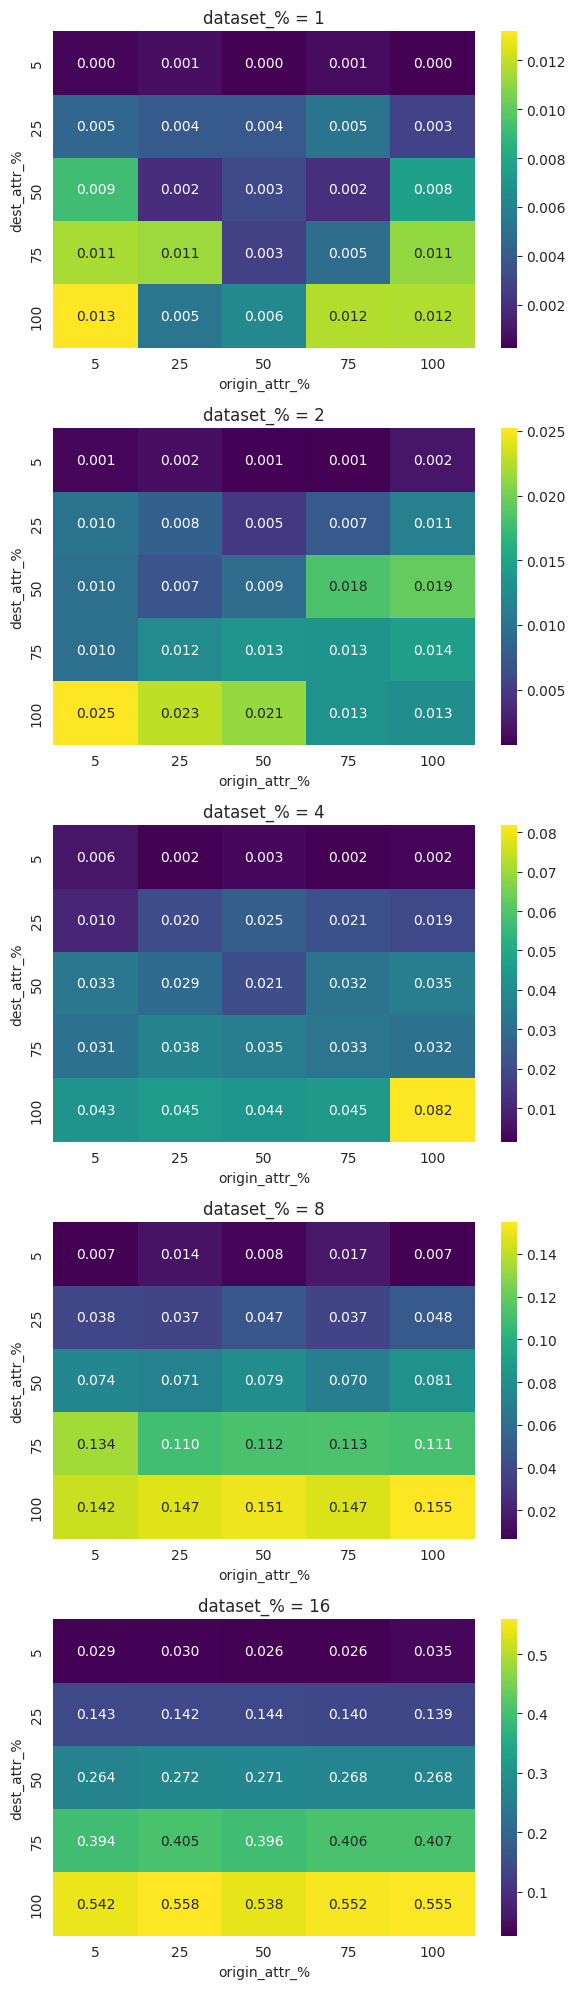

In [123]:
# Heatmap por dataset_% simplificado: subplots verticales
acc_col = 'acc_bin_load_time (s)'
x_col = 'origin_attr_%'
y_col = 'dest_attr_%'
p_col = 'dataset_%'

unique_p = sorted(df[p_col].dropna().unique())
n = len(unique_p)
if n == 0:
    print('\nNo dataset_% values found to build per-percentage heatmaps.')
else:
    if n == 1:
        fig, ax = plt.subplots(figsize=(6, 4))
        axes = [ax]
    else:
        fig, axes = plt.subplots(n, 1, figsize=(6, 4 * n))
        axes = list(axes)

    for idx, pval in enumerate(unique_p):
        ax = axes[idx]
        sub = df[df[p_col] == pval]
        pivot = sub.pivot_table(index=y_col, columns=x_col, values=acc_col, aggfunc='mean')
        pivot = pivot.sort_index(axis=0).sort_index(axis=1)

        if pivot.size == 0 or np.all(np.isnan(pivot.values)):
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            ax.set_title(f'dataset_% = {pval}')
            ax.set_xlabel('origin_attr_%')
            ax.set_ylabel('dest_attr_%')
            continue

        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='viridis', ax=ax, cbar=True)
        ax.set_title(f'dataset_% = {pval}')
        ax.set_xlabel('origin_attr_%')
        ax.set_ylabel('dest_attr_%')

    # Ocultar ejes extra si los hay
    for extra in axes[n:]:
        extra.axis('off')

    plt.tight_layout()
    plt.show()


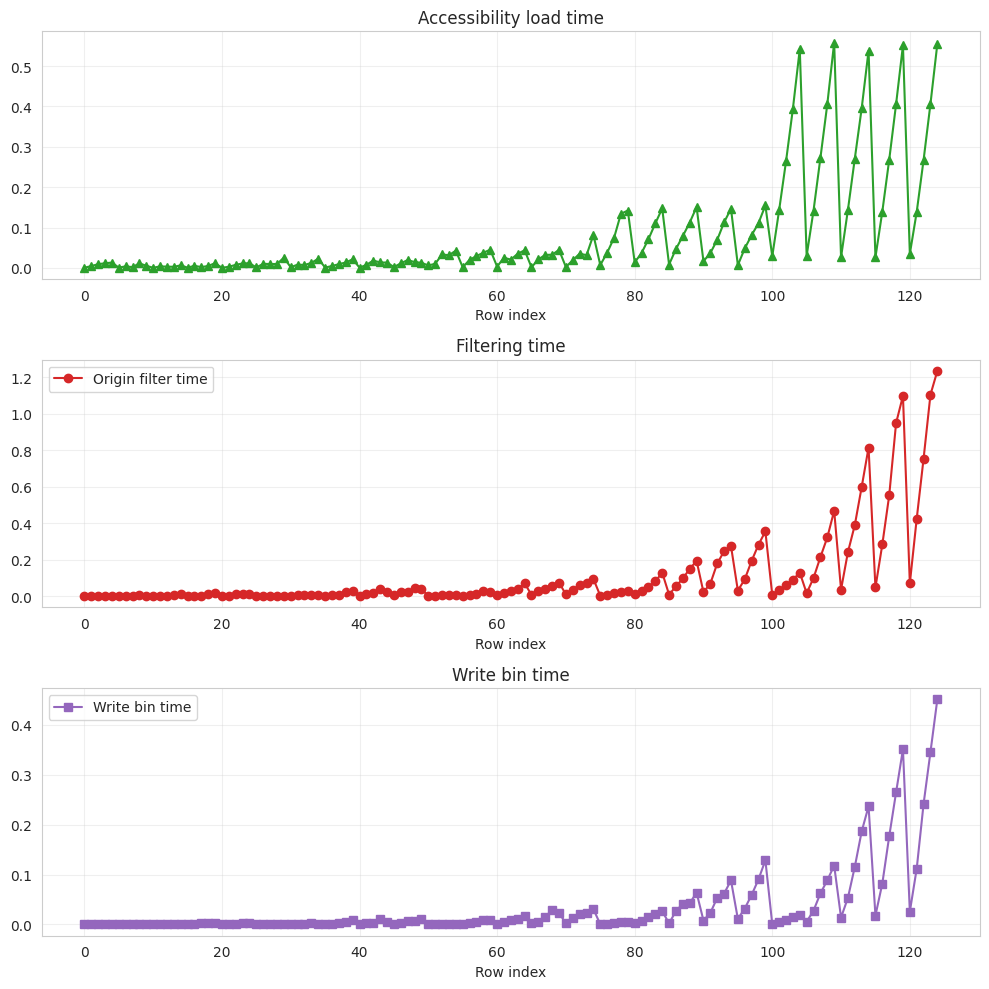

In [124]:
# filtering time analysis
# Plot for all lines in df. line plot

import numpy as np
import matplotlib.pyplot as plt

# Use row index as x-axis (one point per dataset row/entry)
x = np.arange(len(df))

fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharey=False)

# Accessibility
axes[0].plot(x, df['acc_bin_load_time (s)'], marker='^', linestyle='-', color='C2')
axes[0].set_title('Accessibility load time')
axes[0].set_xlabel('Row index')
axes[0].grid(alpha=0.3)

# Filtering time

axes[1].plot(x, df['time_filtering (s)'], marker='o', linestyle='-', color='C3', label='Origin filter time')
axes[1].set_title('Filtering time')
axes[1].set_xlabel('Row index')
axes[1].legend()
axes[1].grid(alpha=0.3)

# time write bin (s)
axes[2].plot(x, df['time_write_bin (s)'], marker='s', linestyle='-', color='C4', label='Write bin time')
axes[2].set_title('Write bin time')
axes[2].set_xlabel('Row index')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()



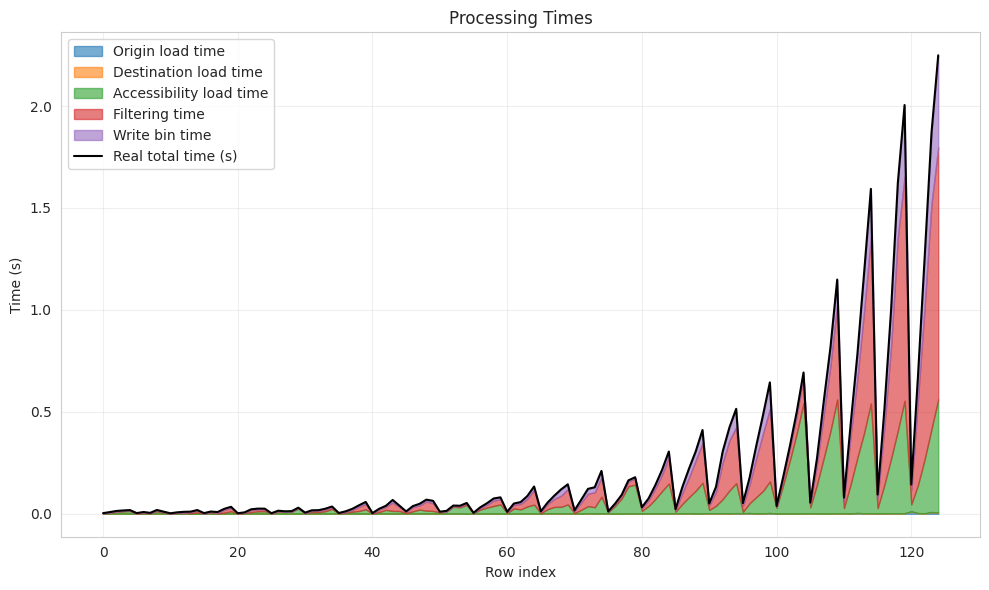

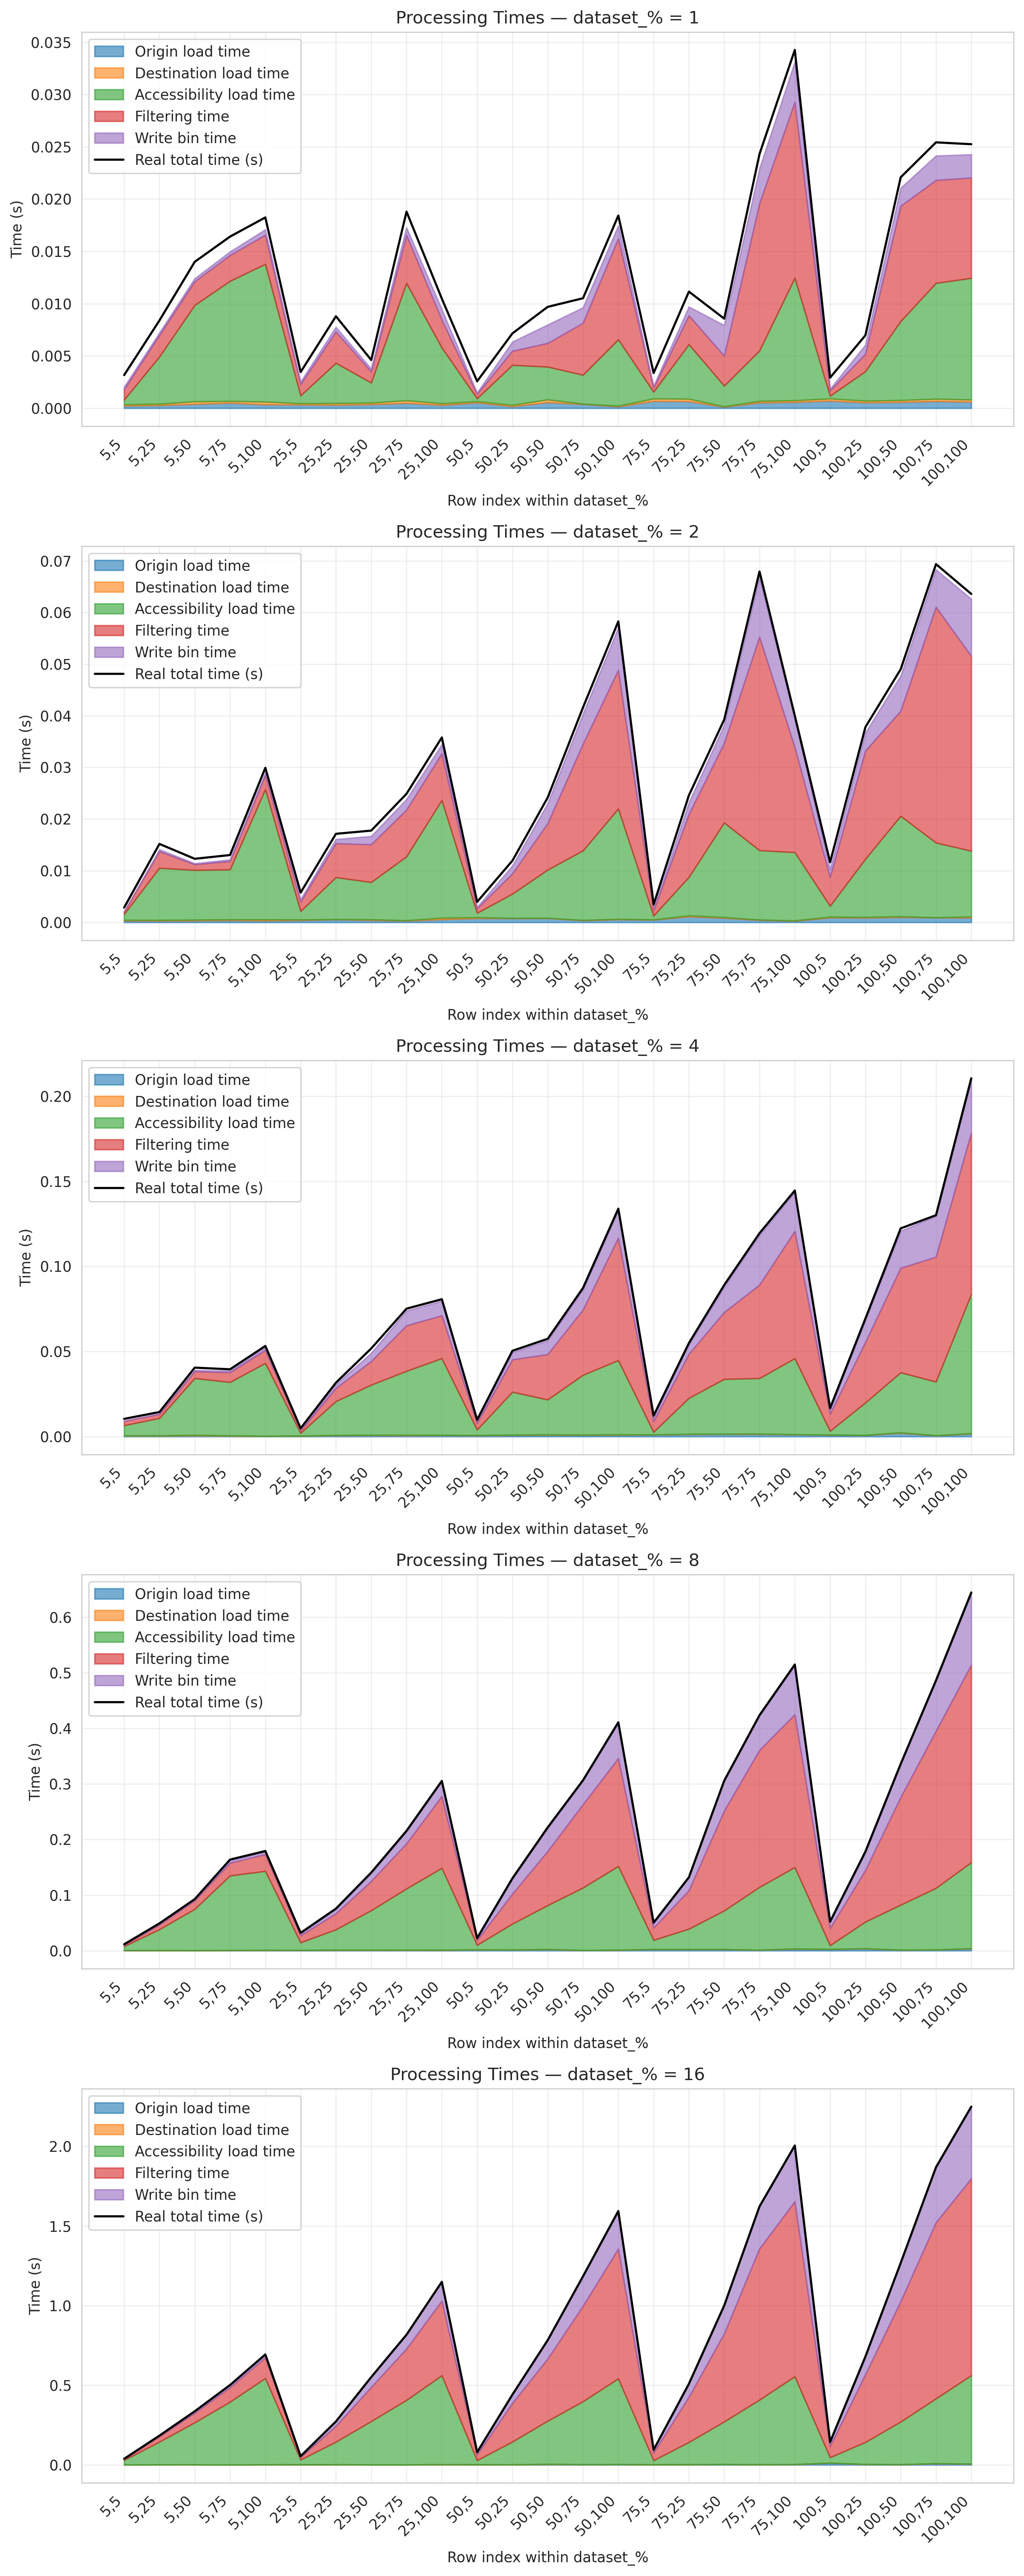

In [125]:
import numpy as np
import matplotlib.pyplot as plt
# Use row index as x-axis (one point per dataset row/entry)
x = np.arange(len(df))
fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(x, 0, df['or_bin_load_time (s)'], label='Origin load time', color='C0', alpha=0.6)
ax.fill_between(x, df['or_bin_load_time (s)'], df['or_bin_load_time (s)'] + df['dst_bin_load_time (s)'], label='Destination load time', color='C1', alpha=0.6)
ax.fill_between(x, df['or_bin_load_time (s)'] + df['dst_bin_load_time (s)'], df['or_bin_load_time (s)'] + df['dst_bin_load_time (s)'] + df['acc_bin_load_time (s)'], label='Accessibility load time', color='C2', alpha=0.6)
ax.fill_between(x, df['or_bin_load_time (s)'] + df['dst_bin_load_time (s)'] + df['acc_bin_load_time (s)'], df['or_bin_load_time (s)'] + df['dst_bin_load_time (s)'] + df['acc_bin_load_time (s)'] + df['time_filtering (s)'], label='Filtering time', color='C3', alpha=0.6)
ax.fill_between(x, df['or_bin_load_time (s)'] + df['dst_bin_load_time (s)'] + df['acc_bin_load_time (s)'] + df['time_filtering (s)'], df['or_bin_load_time (s)'] + df['dst_bin_load_time (s)'] + df['acc_bin_load_time (s)'] + df['time_filtering (s)'] + df['time_write_bin (s)'], label='Write bin time', color='C4', alpha=0.6)
ax.plot(x, df['total_time (s)'], label='Real total time (s)', color='black', marker='')
ax.set_title('Processing Times')
ax.set_xlabel('Row index')
ax.set_ylabel('Time (s)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# en lugar de hacerlo por index row. vamos a coger las unique de cada porcentaje atribute destino y origen
# una grafica para cada porcentaje en el dataset_%
import numpy as np
import matplotlib.pyplot as plt
unique_p = sorted(df['dataset_%'].dropna().unique())
n = len(unique_p)
if n == 0:
    print('\nNo dataset_% values found to build per-percentage time plots.')
else:
    fig, axes = plt.subplots(n, 1, figsize=(10, 5 * n), dpi=300)
    for idx, pval in enumerate(unique_p):
        ax = axes[idx]
        sub = df[df['dataset_%'] == pval]
        xlabels = sub['origin_attr_%'].astype(str) + "," + sub['dest_attr_%'].astype(str)
        x = np.arange(len(sub))
        ax.fill_between(x, 0, sub['or_bin_load_time (s)'], label='Origin load time', color='C0', alpha=0.6)
        ax.fill_between(x, sub['or_bin_load_time (s)'], sub['or_bin_load_time (s)'] + sub['dst_bin_load_time (s)'], label='Destination load time', color='C1', alpha=0.6)
        ax.fill_between(x, sub['or_bin_load_time (s)'] + sub['dst_bin_load_time (s)'], sub['or_bin_load_time (s)'] + sub['dst_bin_load_time (s)'] + sub['acc_bin_load_time (s)'], label='Accessibility load time', color='C2', alpha=0.6)
        ax.fill_between(x, sub['or_bin_load_time (s)'] + sub['dst_bin_load_time (s)'] + sub['acc_bin_load_time (s)'], sub['or_bin_load_time (s)'] + sub['dst_bin_load_time (s)'] + sub['acc_bin_load_time (s)'] + sub['time_filtering (s)'], label='Filtering time', color='C3', alpha=0.6)
        ax.fill_between(x, sub['or_bin_load_time (s)'] + sub['dst_bin_load_time (s)'] + sub['acc_bin_load_time (s)'] + sub['time_filtering (s)'], sub['or_bin_load_time (s)'] + sub['dst_bin_load_time (s)'] + sub['acc_bin_load_time (s)'] + sub['time_filtering (s)'] + sub['time_write_bin (s)'], label='Write bin time', color='C4', alpha=0.6)
        ax.set_title(f'Processing Times — dataset_% = {pval}')
        ax.set_xlabel('Row index within dataset_%')
        ax.set_xticks(x) 
        ax.set_xticklabels(xlabels, rotation=45, ha='right')
        # draw a line wiht the real time total total_time (s)
        ax.plot(x, sub['total_time (s)'], label='Real total time (s)', color='black', marker='')
        ax.set_ylabel('Time (s)')
        ax.legend()
        ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

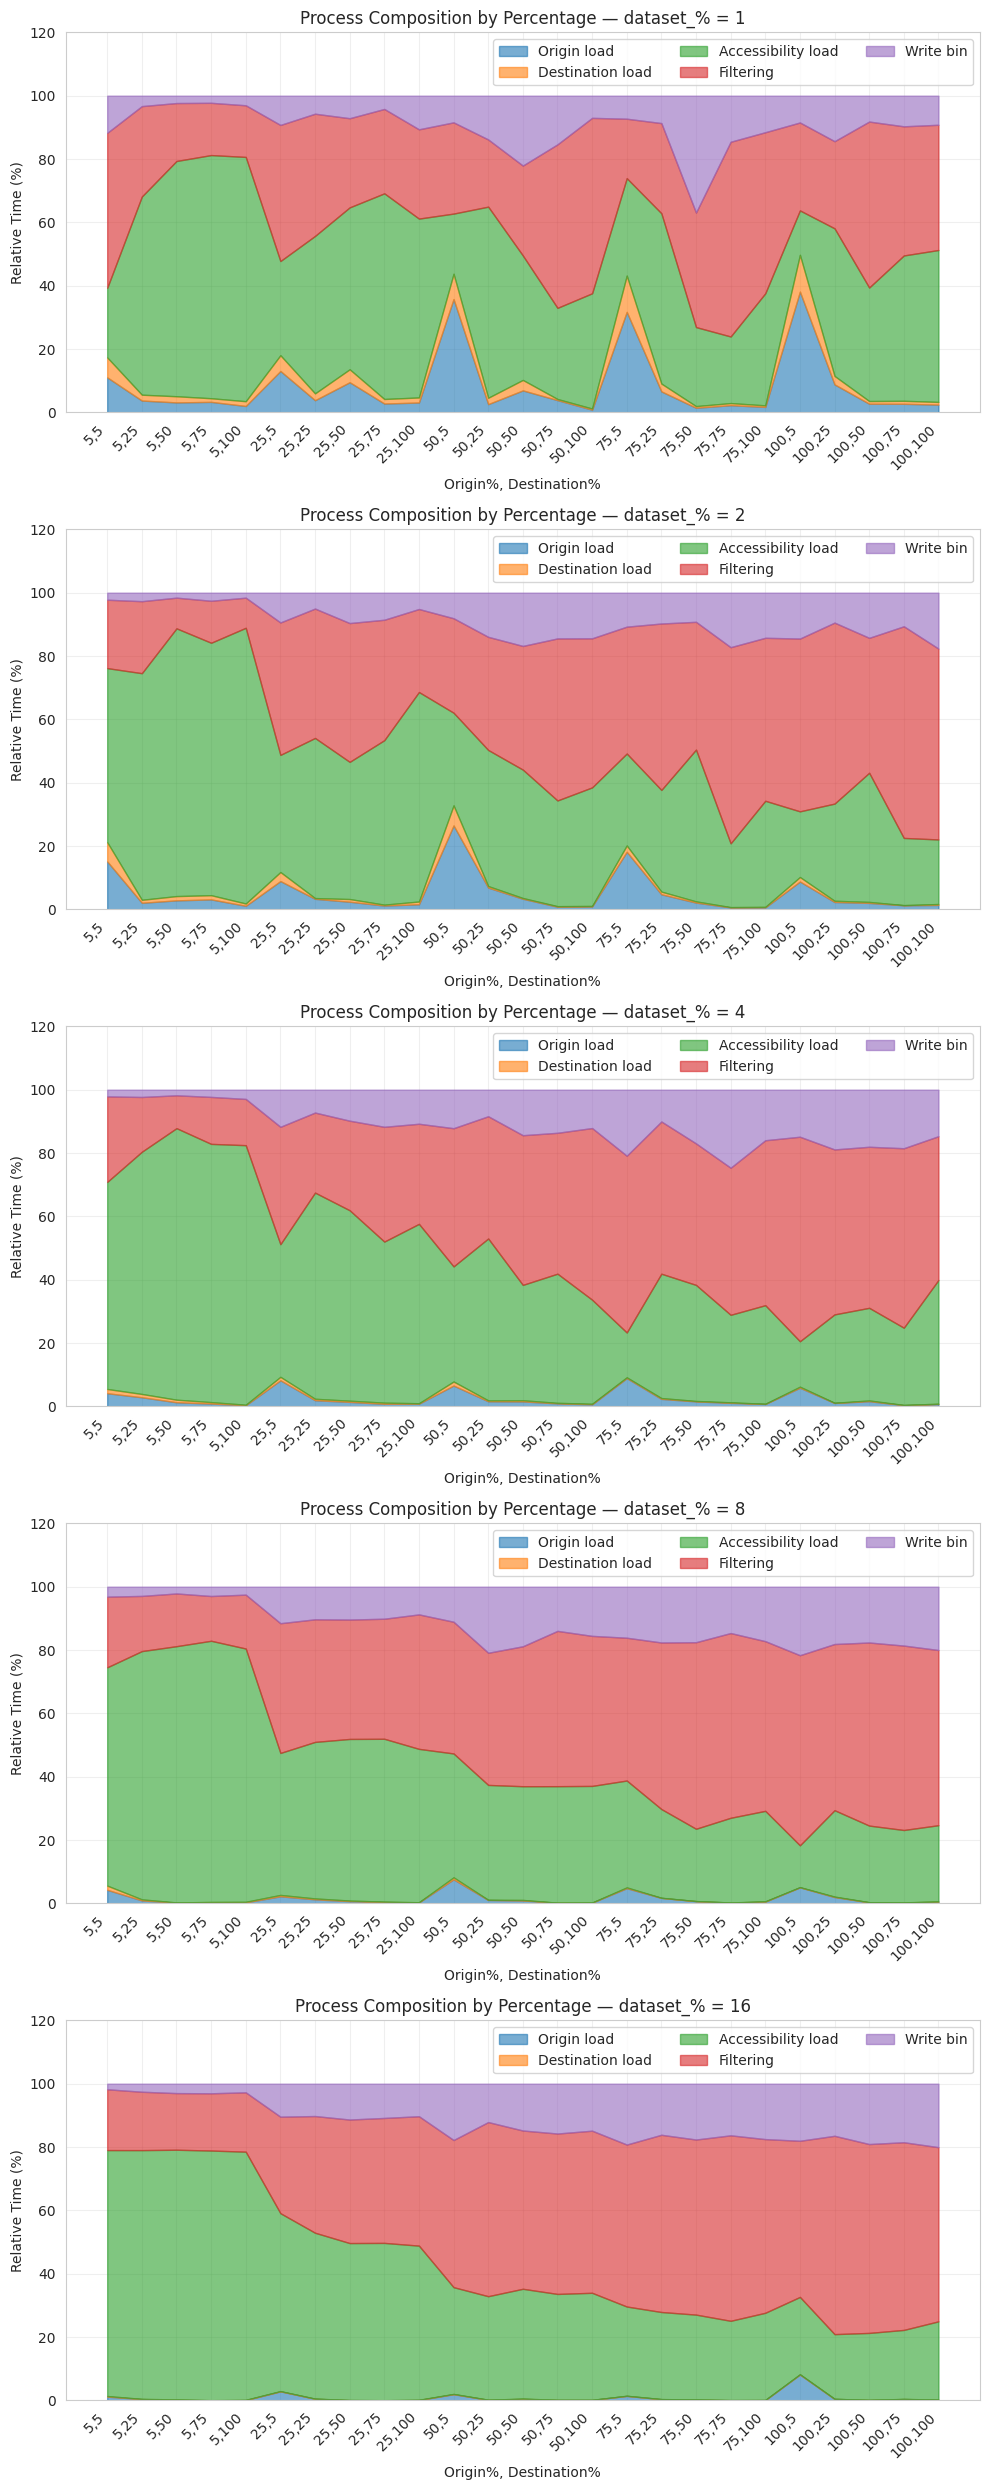

In [126]:
import numpy as np
import matplotlib.pyplot as plt

unique_p = sorted(df['dataset_%'].dropna().unique())
n = len(unique_p)

if n == 0:
    print('\nNo dataset_% values found to build per-percentage time plots.')
else:
    fig, axes = plt.subplots(n, 1, figsize=(10, 5 * n), sharey=False)
    if n == 1:
        axes = [axes]

    for idx, pval in enumerate(unique_p):
        ax = axes[idx]
        sub = df[df['dataset_%'] == pval].copy()

        # --- Compute total as the sum of all relevant components
        total = (
            sub['or_bin_load_time (s)']
            + sub['dst_bin_load_time (s)']
            + sub['acc_bin_load_time (s)']
            + sub['time_filtering (s)']
            + sub['time_write_bin (s)']
        )

        # --- Compute relative proportions (% of this computed total)
        origin = 100 * sub['or_bin_load_time (s)'] / total
        dest   = 100 * sub['dst_bin_load_time (s)'] / total
        acc    = 100 * sub['acc_bin_load_time (s)'] / total
        filt   = 100 * sub['time_filtering (s)'] / total
        write  = 100 * sub['time_write_bin (s)'] / total

        # --- X-axis labels
        x = np.arange(len(sub))
        xlabels = sub['origin_attr_%'].astype(str) + "," + sub['dest_attr_%'].astype(str)

        # --- Stacked (stream-like) proportional plot
        ax.fill_between(x, 0, origin, label='Origin load', color='C0', alpha=0.6)
        ax.fill_between(x, origin, origin + dest, label='Destination load', color='C1', alpha=0.6)
        ax.fill_between(x, origin + dest, origin + dest + acc, label='Accessibility load', color='C2', alpha=0.6)
        ax.fill_between(x, origin + dest + acc, origin + dest + acc + filt, label='Filtering', color='C3', alpha=0.6)
        ax.fill_between(x, origin + dest + acc + filt, origin + dest + acc + filt + write,
                        label='Write bin', color='C4', alpha=0.6)

        ax.set_title(f'Process Composition by Percentage — dataset_% = {pval}')
        ax.set_xlabel('Origin%, Destination%')
        ax.set_ylabel('Relative Time (%)')
        ax.set_xticks(x)
        ax.set_xticklabels(xlabels, rotation=45, ha='right')
        ax.set_ylim(0, 110)
        ax.legend(ncol=3)
        ax.grid(alpha=0.3)
        # y 0,110
        ax.set_ylim(0, 120)

    plt.tight_layout()
    plt.show()

